In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [18]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from matplotlib import pyplot as plt

In [59]:
## Defining Parameter for Models
# vocab_size = 5000
embedding_dim = 100
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [60]:
articles = []
labels = []

with open("bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

2225
2225


In [61]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(articles)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(articles)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

train_size = int(len(articles) * training_portion)
training_sequences = padded[0:train_size]
train_labels = labels[0:train_size]

validation_sequences = padded[train_size:]
validation_labels = labels[train_size:]

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [62]:
print(training_sequences.shape)
print(validation_sequences.shape)
print(training_label_seq.shape)
print(validation_label_seq.shape)

(1780, 200)
(445, 200)
(1780, 1)
(445, 1)


In [94]:
print(vocab_size)
print(word_index['i'])

29698
5519


#### First, we need to load the entire GloVe word embedding file into memory as a dictionary of word to embedding array. Next, we need to create a matrix of one embedding for each word in the training dataset.

In [65]:
# embeddings_index = {};
# with open('glove/glove.6B.100d.txt', "rb") as f:
#     for line in f:
#         values = line.split();
#         word = values[0];
#         coefs = np.asarray(values[1:], dtype='float32')
#         embeddings_index[word] = coefs;

# embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
# for word, i in word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embeddings_matrix[i] = embedding_vector

In [89]:
embeddings_index = {}
f = open('glove/glove.6B.100d.txt', encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [81]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [95]:
# print(len(embeddings_matrix))

#### Now we can define our model, fit, and evaluate it as before.

#### The key difference is that the embedding layer can be seeded with the GloVe word embedding weights.

##### We do not want to update the learned word weights in this model, therefore we will set the trainable attribute for the model to be False.

In [102]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=6),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 200, 100)          2969900   
_________________________________________________________________
dropout_17 (Dropout)         (None, 200, 100)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 196, 64)           32064     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 32, 64)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 390       
Total params: 3,035,378
Trainable params: 65,478
Non-trainable params: 2,969,900
______________________________________

In [103]:
num_epochs = 10
history = model.fit(training_sequences, training_label_seq, epochs=num_epochs, validation_data=(validation_sequences, validation_label_seq), verbose=2)

Epoch 1/10
56/56 - 2s - loss: 1.6522 - accuracy: 0.2039 - val_loss: 1.6178 - val_accuracy: 0.1483
Epoch 2/10
56/56 - 2s - loss: 1.6121 - accuracy: 0.2275 - val_loss: 1.6116 - val_accuracy: 0.2270
Epoch 3/10
56/56 - 2s - loss: 1.6136 - accuracy: 0.2320 - val_loss: 1.5982 - val_accuracy: 0.2270
Epoch 4/10
56/56 - 2s - loss: 1.6110 - accuracy: 0.2331 - val_loss: 1.6127 - val_accuracy: 0.2270
Epoch 5/10
56/56 - 2s - loss: 1.6088 - accuracy: 0.2169 - val_loss: 1.6109 - val_accuracy: 0.2382
Epoch 6/10
56/56 - 2s - loss: 1.6092 - accuracy: 0.2326 - val_loss: 1.6053 - val_accuracy: 0.2382
Epoch 7/10
56/56 - 2s - loss: 1.6094 - accuracy: 0.2303 - val_loss: 1.6054 - val_accuracy: 0.2270
Epoch 8/10
56/56 - 1s - loss: 1.6088 - accuracy: 0.2174 - val_loss: 1.6030 - val_accuracy: 0.2270
Epoch 9/10
56/56 - 1s - loss: 1.6085 - accuracy: 0.2287 - val_loss: 1.6011 - val_accuracy: 0.2270
Epoch 10/10
56/56 - 2s - loss: 1.6081 - accuracy: 0.2140 - val_loss: 1.6007 - val_accuracy: 0.2382


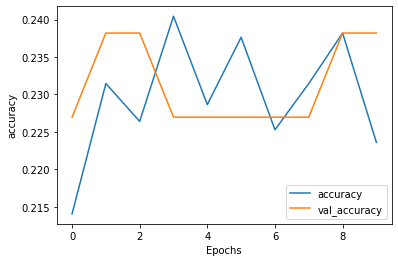

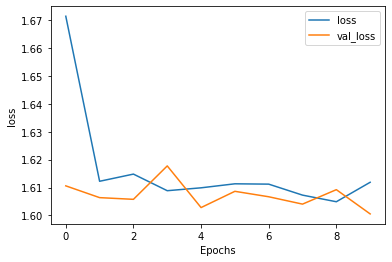

In [87]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss");